In [2]:
!pip install d2l==1.0.0-beta0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.5 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616821 sha256=a6434385efa9bf4a5d8461a830961245aed1943dc79dfbc630ae41c17fa239ee
  Stored in directory: /root/.cache/pip/wheels/b3/50/6c/0a82c1358b4da2dbd9c1bb17e0f89467db32812ab236dbf6d5
Successfully built gym
  Attempting uninstal

Bây giờ ta đã sẵn sàng kết hợp tất cả các công cụ lại với nhau để triển khai mạng nơ-ron tích chập hoàn chỉnh đầu tiên. Lần đầu làm việc với dữ liệu ảnh, ta đã áp dụng một perceptron đa tầng (Section 4.2) cho ảnh quần áo trong bộ dữ liệu Fashion-MNIST. Mỗi ảnh trong Fashion-MNIST là một ma trận hai chiều có kích thước $28×28$. Để tương thích với đầu vào dạng vector một chiều với độ dài cố định của các perceptron đa tầng, đầu tiên ta trải phẳng từng hình ảnh và thu được các vector có chiều dài 784, trước khi xử lý chúng với một chuỗi các tầng kết nối đầy đủ.

Bây giờ đã có các tầng tích chập, ta có thể giữ nguyên ảnh đầu vào ở dạng không gian hai chiều như ảnh gốc và xử lý chúng với một chuỗi các tầng tích chập liên tiếp. Hơn nữa, vì ta đang sử dụng các tầng tích chập, số lượng tham số cần thiết sẽ giảm đi đáng kể.

Trong phần này, chúng tôi sẽ giới thiệu một trong những mạng nơ-ron tích chập được công bố đầu tiên. Ưu điểm của mạng tích chập được minh hoạ lần đầu bởi Yann Lecun (lúc đó đang nghiên cứu tại AT&T Bell Labs) với ứng dụng nhận dạng các số viết tay trong ảnh-LeNet5. Vào những năm 90, các thí nghiệm của các nhà nghiên cứu với LeNet đã đưa ra bằng chứng thuyết phục đầu tiên về tính khả thi của việc huấn luyện mạng nơ-ron tích chập bằng lan truyền ngược. Mô hình của họ đã đạt được kết quả rất tốt (chỉ có Máy Vector Hỗ trợ — SVM tại thời điểm đó là có thể sánh bằng) và đã được đưa vào sử dụng để nhận diện các chữ số khi xử lý tiền gửi trong máy ATM. Một số máy ATM vẫn chạy các đoạn mã mà Yann và đồng nghiệp Leon Bottou đã viết vào những năm 1990!

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

# 7.6.1. LeNet

Một cách đơn giản, ta có thể xem LeNet gồm hai phần: (i) một khối các tầng tích chập; và (ii) một khối các tầng kết nối đầy đủ. Trước khi đi vào các chi tiết cụ thể, hãy quan sát tổng thể mô hình trong hình dưới.

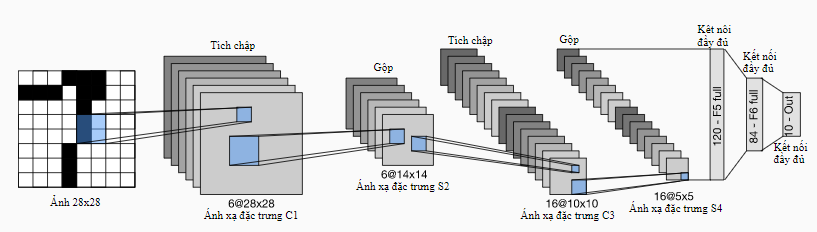

Các đơn vị cơ bản trong khối tích chập là một tầng tích chập và một lớp gộp trung bình theo sau (lưu ý rằng gộp cực đại hoạt động tốt hơn, nhưng nó chưa được phát minh vào những năm 90). Tầng tích chập được sử dụng để nhận dạng các mẫu không gian trong ảnh, chẳng hạn như các đường cạnh và các bộ phận của vật thể, lớp gộp trung bình phía sau được dùng để giảm số chiều. Khối tầng tích chập tạo nên từ việc xếp chồng các khối nhỏ gồm hai đơn vị cơ bản này. Mỗi tầng tích chập sử dụng hạt nhân có kích thước $5×5$ và xử lý mỗi đầu ra với một hàm kích hoạt sigmoid (nhấn mạnh rằng ReLU hiện được biết là hoạt động đáng tin cậy hơn, nhưng chưa được phát minh vào thời điểm đó). Tầng tích chập đầu tiên có 6 kênh đầu ra và tầng tích chập thứ hai tăng độ sâu kênh hơn nữa lên 16.

Tuy nhiên, cùng với sự gia tăng số lượng kênh này, chiều cao và chiều rộng lại giảm đáng kể. Do đó, việc tăng số lượng kênh đầu ra làm cho kích thước tham số của hai tầng tích chập tương tự nhau. Hai lớp gộp trung bình có kích thước $2×2$ và sải bước bằng 2 (điều này có nghĩa là chúng không chồng chéo). Nói cách khác, lớp gộp giảm kích thước của các biểu diễn còn một phần tư kích thước trước khi gộp.

Đầu ra của khối tích chập có kích thước được xác định bằng (kích thước batch, kênh, chiều cao, chiều rộng). Trước khi chuyển đầu ra của khối tích chập sang khối kết nối đầy đủ, ta phải trải phẳng từng mẫu trong minibatch. Nói cách khác, ta biến đổi đầu vào 4D thành đầu vào 2D tương thích với các tầng kết nối đầy đủ: nhắc lại, chiều thứ nhất là chỉ số các mẫu trong minibatch và chiều thứ hai là biểu diễn vector phẳng của mỗi mẫu. Khối tầng kết nối đầy đủ của LeNet có ba tầng kết nối đầy đủ, với số lượng đầu ra lần lượt là 120, 84 và 10. Bởi vì ta đang thực hiện bài toán phân loại, tầng đầu ra 10 chiều tương ứng với số lượng các lớp đầu ra khả thi (10 chữ số từ 0 đến 9).

Để thực sự hiểu những gì diễn ra bên trong LeNet có thể đòi hỏi một chút nỗ lực, tuy nhiên bạn có thể thấy bên dưới đây việc lập trình Lenet bằng thư viện học sâu hiện đại rất đơn giản. Một lần nữa, ta sẽ dựa vào lớp Sequential.



In [4]:
def init_cnn(module):  
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):  
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

Chúng ta có một số tự do trong việc tái tạo LeNet trong chừng mực khi chúng tôi thay thế lớp kích hoạt Gaussian bằng một lớp softmax. Điều này giúp đơn giản hóa rất nhiều việc triển khai, đặc biệt là do bộ giải mã Gaussian ngày nay hiếm khi được sử dụng. Ngoài ra, mạng này phù hợp với kiến ​​trúc LeNet-5 ban đầu.

Hãy xem điều gì xảy ra bên trong mạng. Bằng cách chuyển một kênh đơn (đen trắng) $28 \times 28$ hình ảnh qua mạng và in hình dạng đầu ra ở mỗi lớp, chúng ta có thể kiểm tra mô hình để đảm bảo rằng các hoạt động của nó phù hợp với những gì chúng ta mong đợi từ hình dưới.

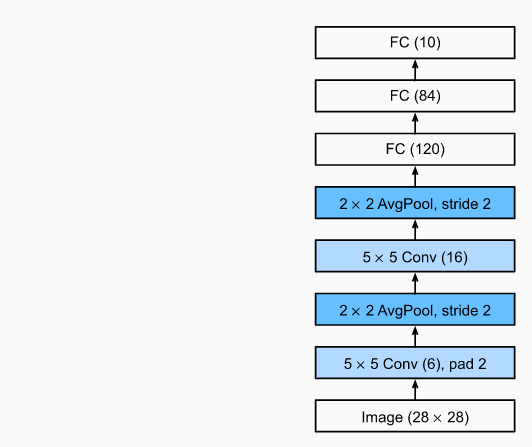

In [5]:
@d2l.add_to_class(d2l.Classifier) 
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Xin hãy chú ý rằng, chiều cao và chiều rộng của biểu diễn sau mỗi tầng trong toàn bộ khối tích chập sẽ giảm theo chiều sâu của mạng(so với chiều cao và chiều rộng của biểu diễn ở tầng trước). Tầng tích chập đầu tiên sử dụng một hạt nhân với chiều cao và chiều rộng là $5$ rồi đệm thêm $2$ đơn vị điểm ảnh để giữ nguyên kích thước đầu vào. Trong khi đó, tầng tích chập thứ hai cũng dùng cùng một hạt nhân với kích thước là $5×5$ mà không có sử dụng giá trị đệm thêm vào, dẫn đến việc chiều cao và chiều rộng giảm đi 4 đơn vị điểm ảnh. Ngoài ra, mỗi tầng gộp sẽ làm giảm đi một nửa chiều cao và chiều rộng của đặc trưng ánh xạ đầu vào. Tuy nhiên, khi chúng ta đi theo chiều sâu của mạng, số kênh sẽ tăng lần lượt theo từng tầng. Từ 1 kênh của dữ liệu đầu vào lên tới 6 kênh sau tầng tích chập thứ nhất và 16 kênh sau tầng tích chập thứ hai. Sau đó,giảm số chiều lần lượt qua từng tầng kết nối đầy đủ đến khi trả về một đầu ra có kích thước bằng số lượng lớp của hình ảnh.

# 7.6.2. Training

Bây giờ chúng ta đã triển khai mô hình, hãy chạy thử nghiệm để xem mô hình LeNet-5 hoạt động như thế nào trên Fashion-MNIST.

Mặc dù các CNN có ít tham số hơn, nhưng chúng vẫn có thể tốn kém hơn để tính toán so với các MLP sâu tương tự vì mỗi tham số tham gia vào nhiều phép nhân hơn. Nếu bạn có quyền truy cập vào GPU, đây có thể là thời điểm tốt để đưa nó vào hoạt động để tăng tốc độ đào tạo. Lưu ý rằng Class d2l.Trainer học sẽ chăm sóc tất cả các chi tiết. Theo mặc định, nó khởi tạo các tham số mô hình trên các thiết bị có sẵn. Cũng giống như với MLP, hàm mất mát của chúng tôi là entropy chéo và chúng tôi giảm thiểu nó thông qua việc giảm độ dốc ngẫu nhiên của minibatch.

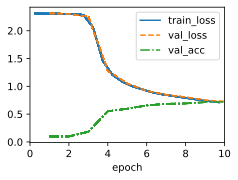

In [9]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)